In [2]:
#%%
import requests
import json
import pandas as pd

In [23]:
token = "Your token here"
headers = {"content-type" : "application/json", "Authorization" : token, "JWT-AUD": 'Cost Analysis'}

def run_query(query): # A simple function to use requests.post to make the API call. Note the json= section.
    request = requests.post('https://api.sorare.com/graphql', json={'query': query}, headers = headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))
        
# The GraphQL query (with a few aditional bits included) itself defined as a multi-line string.       
query = """
query{
	player(slug: "sandro-tonali"){
    slug
  	cards(first:1000){
      nodes{
        name
        canBuy
        rarity
        priceRange{
          min
          max
        }
        publicMinPrice
        privateMinPrice
        
      }
      }
  }}
  """

result = run_query(query) # Execute the query
#%%
df = pd.json_normalize(result['data']['player']['cards']['nodes'])

# %%

In [10]:
from __future__ import annotations

In [4]:
key = "YOUR API KEY HERE"
last_name = 'skriniar'

In [5]:
def get_player_id(
    last_name : str = None,
    api_key : str = None
    ) -> pd.DataFrame:

    url = f"https://api-football-v1.p.rapidapi.com/v2/players/search/{last_name}"
    headers = {
        'x-rapidapi-host': "api-football-v1.p.rapidapi.com",
        'x-rapidapi-key': api_key
        }
    
    player_search_rsp = requests.request("GET", url, headers = headers)
    player_search_df = pd.json_normalize(player_search_rsp.json()['api']['players'])
    return player_search_df

skriniar = get_player_id(last_name = last_name, api_key = key)

In [6]:
skriniar

,player_id,player_name,firstname,lastname,number,position,age,birth_date,birth_place,birth_country,nationality,height,weight
0,198,M. Škriniar,Milan,Škriniar,None,Defender,27,11/02/1995,Žiar nad Hronom,Slovakia,Slovakia,187 cm,80 kg


In [11]:
def player_stats(id : int, api_key : str, szn: str | None = None) -> pd.DataFrame:
    if szn is not None:
        url = f"https://api-football-v1.p.rapidapi.com/v2/players/player/{id}/{szn}"
    else:
        url = f"https://api-football-v1.p.rapidapi.com/v2/players/player/{id}"
        
    headers = {
    'x-rapidapi-host': "api-football-v1.p.rapidapi.com",
    'x-rapidapi-key': api_key
    }

    player_stat_rsp = requests.request("GET", url, headers = headers)
    player_stat_df = pd.json_normalize(player_stat_rsp.json()['api']['players'])

    return player_stat_df


In [17]:
def get_last_fixtures(team_id : int, api_key : str, num_fixts : int = 5) -> pd.DataFrame:
    
    url = f"https://api-football-v1.p.rapidapi.com/v2/fixtures/team/{team_id}/last/{num_fixts}"
        
    headers = {
    'x-rapidapi-host': "api-football-v1.p.rapidapi.com",
    'x-rapidapi-key': api_key
    }

    last_fixture_rsp = requests.request("GET", url, headers = headers)
    last_fixture_df = pd.json_normalize(last_fixture_rsp.json()['api']['fixtures'])
    return last_fixture_df


In [18]:
def get_next_fixtures(team_id : int, api_key : str, num_fixts : int = 5) -> pd.DataFrame:
    
    url = f"https://api-football-v1.p.rapidapi.com/v2/fixtures/team/{team_id}/next/{num_fixts}"
        
    headers = {
    'x-rapidapi-host': "api-football-v1.p.rapidapi.com",
    'x-rapidapi-key': api_key
    }

    next_fixture_rsp = requests.request("GET", url, headers = headers)
    next_fixture_df = pd.json_normalize(next_fixture_rsp.json()['api']['fixtures'])
    return next_fixture_df


In [19]:
def get_fixture_stats(fixture_id: int, player_id : int, api_key : str):
    url = f"https://api-football-v1.p.rapidapi.com/v2/players/fixture/{fixture_id}"

    headers = {
    'x-rapidapi-host': "api-football-v1.p.rapidapi.com",
    'x-rapidapi-key': api_key
    }

    fixture_stats = requests.request("GET", url, headers = headers)
    fixture_stats_df = pd.json_normalize(fixture_stats.json()['api']['players'])
    player_fixture_stats = fixture_stats_df[fixture_stats_df['player_id'] == player_id]
    return player_fixture_stats


In [20]:
def get_last_x_stats(team_id : int, player_id : int, api_key : str, num_fixts: int = 5):
    last_fixtures = get_last_fixtures(team_id, api_key, num_fixts)

    f_stats = pd.DataFrame()
    
    for i in range(num_fixts):
        f_id = last_fixtures.iloc[i]['fixture_id']
        temp_df = get_fixture_stats(f_id,player_id,api_key)
        temp_df['team_1'] = last_fixtures.iloc[i]['homeTeam.team_name']
        temp_df['team_2'] = last_fixtures.iloc[i]['awayTeam.team_name']
        f_stats = pd.concat([f_stats, temp_df]).reset_index(drop=True)
    
    return f_stats


In [29]:
last_fixture = get_last_x_stats(505,198,key,15)


In [49]:
last_fixture['fixture'] = last_fixture['team_1'] + ' - ' + last_fixture['team_2']

In [50]:
reversed_last_fixture = last_fixture.iloc[::-1]

In [51]:
from scipy.interpolate import make_interp_spline
import numpy as np

In [70]:
reversed_last_fixture = reversed_last_fixture[~reversed_last_fixture['rating'].isnull()]

In [72]:
reversed_last_fixture = reversed_last_fixture.reset_index(drop=True)

In [73]:
np.arange(0,len(reversed_last_fixture),1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [78]:
retry = make_interp_spline(np.arange(0,len(reversed_last_fixture),1), pd.to_numeric(reversed_last_fixture['rating']))
 
X_ = np.linspace(0, len(reversed_last_fixture), 1000)
Y_ = retry(X_)

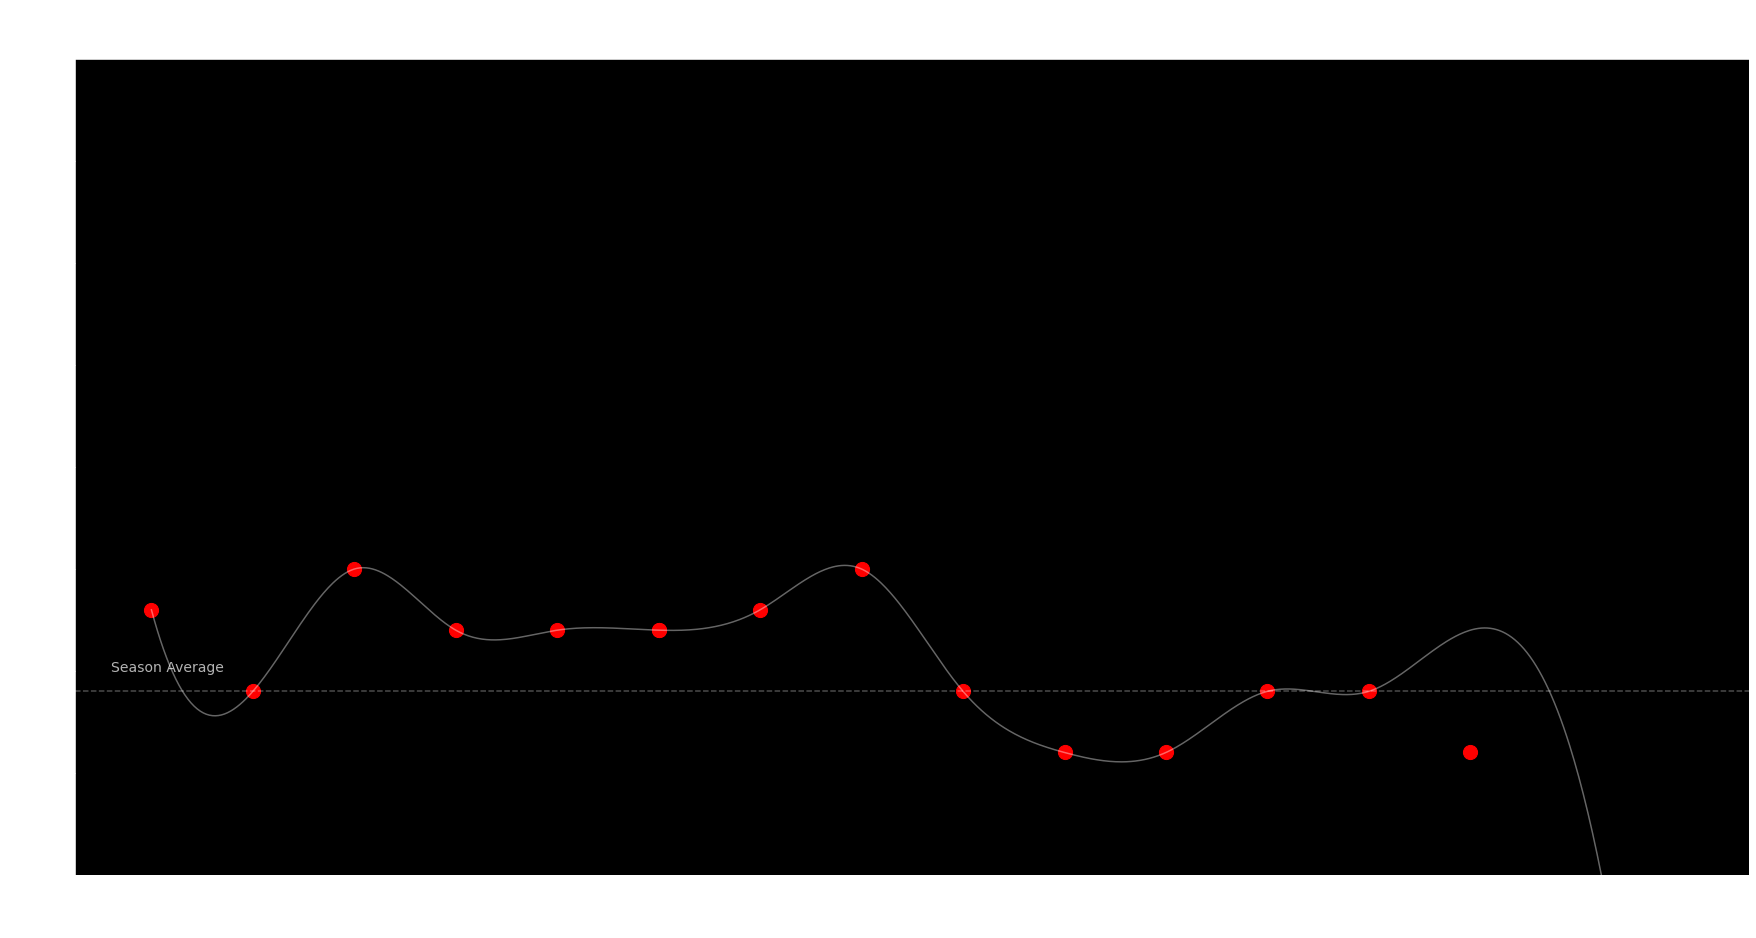

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = plt.figure(figsize = (30,15))
hfont = {'fontname':'Helvetica'}


with plt.style.context('dark_background'):
    plt.plot(X_, Y_, alpha = 0.4, color = 'white')
    plt.scatter(y = pd.to_numeric(reversed_last_fixture['rating']), x =reversed_last_fixture['fixture'], s = 200 , color = 'red')
    plt.axhline(y = 6.9, alpha = 0.3, color = 'w', linestyle = 'dashed')
    plt.text(y = 7.0, s= 'Season Average', x = -0.4, ha = 'left', fontsize = 14, color = 'w', alpha = 0.7, **hfont)
    plt.title("Milan Skriniar | Last 10 Games", fontsize = 30, pad = 30, **hfont)
    plt.ylabel("Match Rating (Football API)", fontsize = 20, labelpad = 20, **hfont)
    plt.xlabel("Serie A Fixture", fontsize = 20, labelpad = 20, **hfont)
    plt.ylim([6,10])